In [1]:
import os
import re
import functools
import numpy as np
import pandas as pd
import pickle5 as pickle

In [25]:
# CURR_PATH = os.getcwd()
CURR_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM'
DATA_PATH = '/home/svetlanamaslenkova/Documents/data/physionet.org/files/mimiciv/2.0/'
DF_PATH = CURR_PATH +'/dataframes_2/'
# ED_PATH = DATA_PATH+'physionet.org/files/mimic-iv-ed/1.0/ed/'
PKL_PATH = CURR_PATH+'/pickles_2/'
DF_PATH = CURR_PATH+'/dataframes_2/'
ICU_PATH = DATA_PATH + 'icu/'
HOSP_PATH = DATA_PATH + 'hosp/'

In [5]:
with open(PKL_PATH + 'aki_stage_labels.pkl', 'rb') as f:
    aki_stage_labels = pickle.load(f)
aki_stage_labels.head()   

,subject_id,hadm_id,stay_id,specimen_id,day_id,icu_day_id,icu_12h_window_id,charttime,intime,AKI_1_scr,AKI_2_scr,AKI_3_scr,AKI_1_urine,AKI_2_urine,AKI_3_urine,AKI_1,AKI_2,AKI_3,ANY_AKI
0,16788749,20000808,30610654,63232011.0,5,0,0,2180-01-18 01:54:00,2180-01-17 19:32:10,0,0,0,0.0,0.0,0.0,0,0,0,0
1,16788749,20000808,30610654,72894600.0,6,1,2,2180-01-19 03:36:00,2180-01-17 19:32:10,0,0,0,1.0,0.0,0.0,1,0,0,1
2,16003661,20001305,36916968,90355490.0,0,0,0,2178-03-25 13:45:00,2178-03-25 02:59:09,0,0,0,1.0,1.0,1.0,0,0,1,1
3,16003661,20001305,36916968,92318652.0,1,1,3,2178-03-27 02:12:00,2178-03-25 02:59:09,1,0,0,1.0,1.0,1.0,0,0,1,1
4,14577567,20001361,33475095,96321141.0,0,0,0,2143-05-05 04:27:00,2143-05-04 16:52:00,1,0,0,0.0,0.0,0.0,1,0,0,1


In [66]:
with open(PKL_PATH + 'aki_stage_labels_second_day.pkl', 'rb') as f:
    aki_stage_labels_second_day = pickle.load(f)
aki_stage_labels_second_day

,subject_id,hadm_id,stay_id,AKI_1,AKI_2,AKI_3,ANY_AKI,NO_AKI
0,18421337,22413411,30000484,0,0,0,0,1
1,12168737,29283664,30001336,0,0,0,0,1
2,34923988,59074770,30001471,0,0,0,0,1
3,13269859,26734917,30002521,0,0,0,0,1
4,15978672,26652960,30002654,1,0,0,1,0
...,...,...,...,...,...,...,...,...
33801,38093900,48704302,39998622,0,1,0,1,0
33802,15669140,29818488,39999172,0,0,0,0,1
33803,13651601,22584645,39999230,0,1,0,1,0
33804,15403458,25335698,39999562,0,0,0,0,1


In [21]:
with open(PKL_PATH + 'chartevents_creatinine.pkl', 'rb') as f:
    chartevents_creatinine = pickle.load(f)

In [26]:
import pandas as pd

data_icustays = pd.read_csv(ICU_PATH + 'icustays.csv')

data_icustays.columns = data_icustays.columns.str.lower()

data_icustays.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [27]:
data_icustays['hadm_id'] = data_icustays['hadm_id'].astype(int)
# change charttime column to datettime type
format_ = '%Y-%m-%d %H:%M:%S'
data_icustays['intime'] = pd.to_datetime(data_icustays['intime'], format=format_)
data_icustays['outtime'] = pd.to_datetime(data_icustays['outtime'], format=format_)

# Whole cohort

In [67]:
print('number of stays with aki status available from ICU wards: ', \
                    aki_stage_labels_second_day.stay_id.unique().shape[0])
g_adm = aki_stage_labels_second_day.groupby('stay_id').sum()
print('admissions with no AKI in ICU: ', g_adm[g_adm.ANY_AKI==0].index.shape[0])
print('admissions with AKI 1 in ICU: ', aki_stage_labels_second_day[aki_stage_labels_second_day.AKI_1==1].stay_id.unique().shape[0])
print('admissions with AKI 2 in ICU: ', aki_stage_labels_second_day[aki_stage_labels_second_day.AKI_2==1].stay_id.unique().shape[0])
print('admissions with AKI 3 in ICU: ', aki_stage_labels_second_day[aki_stage_labels_second_day.AKI_3==1].stay_id.unique().shape[0])

number of stays with aki status available from ICU wards:  33806
admissions with no AKI in ICU:  20100
admissions with AKI 1 in ICU:  6239
admissions with AKI 2 in ICU:  3560
admissions with AKI 3 in ICU:  3907


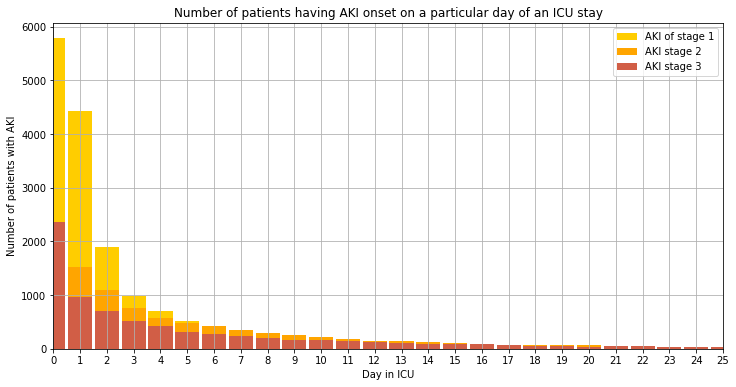

In [20]:
from turtle import color
from matplotlib import pyplot as plt
icu_aki_status = aki_stage_labels.copy()

g0 = icu_aki_status[(icu_aki_status.AKI_1==1)].sort_values(['hadm_id', 'icu_12h_window_id'])\
                        .drop_duplicates(['stay_id'], keep='first')\
                            .groupby('icu_day_id')\
                                .count()
index0 = g0.AKI_1.sort_values(ascending=False).index
values0 = g0.AKI_1.sort_values(ascending=False).values

g1 = icu_aki_status[(icu_aki_status.AKI_1==1)&(icu_aki_status.AKI_2==0)].sort_values(['hadm_id', 'icu_12h_window_id'])\
                        .drop_duplicates(['stay_id'], keep='first')\
                            .groupby('icu_day_id')\
                                .count()
index1 = g1.AKI_1.sort_values(ascending=False).index
values1 = g1.AKI_1.sort_values(ascending=False).values

g2 = icu_aki_status[(icu_aki_status.AKI_2==1)&(icu_aki_status.AKI_3==0)].sort_values(['hadm_id', 'icu_12h_window_id'])\
                        .drop_duplicates(['stay_id'], keep='first')\
                            .groupby('day_id')\
                                .count()
index2 = g2.AKI_2.sort_values(ascending=False).index
values2 = g2.AKI_2.sort_values(ascending=False).values

g3 = icu_aki_status[icu_aki_status.AKI_3==1].sort_values(['hadm_id', 'icu_12h_window_id'])\
                        .drop_duplicates(['stay_id'], keep='first')\
                            .groupby('day_id')\
                                .count()
index3 = g3.AKI_3.sort_values(ascending=False).index
values3 = g3.AKI_3.sort_values(ascending=False).values

fig, (ax2) = plt.subplots(1, 1, figsize=(12, 6), sharex=False) 

ax2.set_xticks(index1)
# ax2.set_yticks(np.arange(0, 3000, 100))
ax2.set_xlim([0,25])
ax2.set_xlabel('Day in ICU')
ax2.set_ylabel('Number of patients with AKI')
# ax2.bar(index0, values0, width=0.9, label='AKI of any stage')
ax2.bar(index1, values1, width=0.9, label='AKI of stage 1', color='#FFCD00')
ax2.bar(index2, values2, width=0.9, label='AKI stage 2', color='orange')
ax2.bar(index3, values3, width=0.9, label='AKI stage 3', color='#D15E46')
ax2.set_title('Number of patients having AKI onset on a particular day of an ICU stay')
ax2.grid(True)
ax2.legend()

plt.show()

0.0 110.23


Text(0.5, 0.98, 'Length of ICU stay')

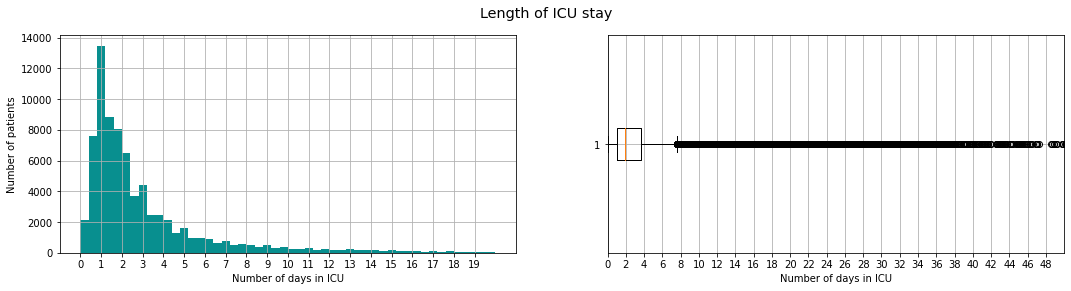

In [28]:
from matplotlib import pyplot as plt

print(np.round(data_icustays.los.min(),2) , np.round(data_icustays.los.max(), 2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4), sharex=False)
ax1.hist(data_icustays.los,  bins=50, range=(0,20),histtype ='bar', facecolor='#088F8F')
ax1.set_xticks(np.arange(0, 20))
ax1.set_xlabel('Number of days in ICU')
ax1.set_ylabel('Number of patients')
ax1.grid()

ax2.boxplot(data_icustays.los, vert=False)
ax2.set_xticks(np.arange(0, 50, 2 ))
ax2.set_xlim([0,50])
ax2.set_xlabel('Number of days in ICU')
ax2.grid()

fig.suptitle("Length of ICU stay", fontsize="x-large")

Creatinine on the first day in the ICU

In [55]:
fisrt_scr_icu = chartevents_creatinine.sort_values(['subject_id','hadm_id','stay_id','charttime'], ascending=True).drop_duplicates(['subject_id','hadm_id','stay_id'], keep='first').sort_values('value', ascending=True)
fisrt_scr_icu['valuenum'] =  fisrt_scr_icu['valuenum'].astype(float)
fisrt_scr_icu.head(1)

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type
928611,17341901,26732570,39786701,2142-10-09 15:30:00,220615,-0.1,-0.1,mg/dL,Creatinine (serum),Creatinine (serum),Labs,None,Numeric


In [54]:
fisrt_scr_icu.value.values

array(['-0.1', '0', '0', ..., '999999', '999999', '999999'], dtype=object)

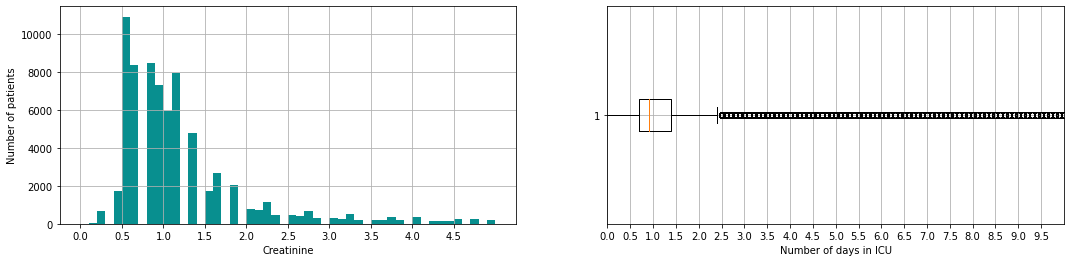

In [64]:
from turtle import width
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4), sharex=False)

ax1.hist(fisrt_scr_icu.valuenum,  bins=50, range=(0,5),  histtype ='bar', facecolor='#088F8F')
ax1.set_xticks(np.arange(0, 5, 0.5))
ax1.set_xlabel('Creatinine')
ax1.set_ylabel('Number of patients')
ax1.grid()

ax2.boxplot(fisrt_scr_icu.valuenum, vert=False)
ax2.set_xticks(np.arange(0, 10, 0.5 ))
ax2.set_xlim([0,10])
ax2.set_xlabel('Number of days in ICU')
ax2.grid()